# Landsat 8 high resolution imagery

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layers
- Querying the data layers
    - Point query
    - Raster query
- References
  
## Overview

This data set provides high resolution imagery from the Landsat 8 satellite from the National Aeronautics and Space Administration (NASA) that includes conditions at the top of the atmosphere.

## Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the config below.

```config.read('../../../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib

In [2]:
import ibmpairs.client as client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import pandas as pd
import configparser
import json
import numpy as np
from PIL import Image as PILImage
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os

Now, let us create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

### Get authentication token

In [4]:
config = configparser.RawConfigParser()
config.read('../../../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id')  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                    tenant_id = EI_TENANT_ID,
                                    org_id    = EI_ORG_ID,
                                    legacy    = False,
                                    version   = 3
                                   )

2025-01-21 13:00:11 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-21 13:00:11 - paw - INFO - Legacy Environment is False
2025-01-21 13:00:11 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-21 13:00:13 - paw - INFO - Authentication success.
2025-01-21 13:00:13 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Data layers
We shall start by querying the catalog to retrieve the Data Set ID and the Data Layers that form the dataset.

In [4]:
pd.set_option('display.max_colwidth', None)
search_df=catalog.search("Landsat 8 high resolution imagery")
search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

dataset_id data_layer_id           data_layer_name  \
0         561         51393  Band 1 (coastal aerosol)   
1         561         51394             Band 2 (blue)   
2         561         51395          Band 11 (TIRS 2)   
3         561         51396        Quality assessment   
4         561         51397            Band 3 (green)   
5         561         51398              Band 4 (red)   
6         561         51399              Band 5 (NIR)   
7         561         51400           Band 6 (SWIR 1)   
8         561         51401           Band 7 (SWIR 2)   
9         561         51402           Band 9 (cirrus)   
10        561         51403          Band 10 (TIRS 1)   

                                                                                                                                                                                                                                           data_layer_description_short  \
0                                                                                 Deep blue and violet band (433 - 453 nm) at 30 m resolution; Called coastal/aerosol band due to two main uses: imaging shallow water and tracking fine particles like dust and smoke.   
1                                                                                                                                                                                                                          Blue band (452 - 512 nm) at 30 m resolution.   
2                                                                                                                                                                                                      Thermal infrared (11500 - 12510 nm) brightness temperature in K    
3   Quality assessment band. "Each pixel in the QA band contains unsigned integers that represent bit-packed combinations of surface, atmospheric, and sensor conditions that can affect the overall usefulness of a given pixel." [Source: USGS Landsat documentation]   
4                                                                                                                                                                                                                         Green band (533 - 590 nm) at 30 m resolution.   
5                                                                                                                                                                                                                           Red band (636 - 673 nm) at 30 m resolution.   
6                                                                                                                                         Near-infrared (NIR) band (851 - 879 nm) at 30 m resolution; It is useful to measure NDVI index, thus monitoring plant health.   
7                                                                Shortwave infrared (SWIR 1) band (1566 - 1651 nm) at 30 m resolution; Together with SWIR 2, it is useful to differentiate wet Earth from dry Earth, and for geology such as rock-soil differentiation.   
8                                                                Shortwave infrared (SWIR 2) band (2107 - 2294 nm) at 30 m resolution; Together with SWIR 1, it is useful to differentiate wet Earth from dry Earth, and for geology such as rock-soil differentiation.   
9                                                                                                                       Cirrus band (1363 - 1384 nm) at 30 m resolution; It covers very thin slice of wavelength, and is designed for clouds, especially cirrus clouds.   
10                                                                                                                                                                                                      Thermal infrared (10600 - 11190 nm) brightness temperature in K   

    data_layer_level data_layer_type data_layer_unit  \
0                 21          Raster                   
1

As seen above, the Landsat 8 high resolution imagery Data Set of ID 561 has eleven Data Layers. This collection provides data layers for a broad range of environmental, ecological, and socio-economic applications, helping decision-makers to monitor, manage, and plan for changes in land use, natural resources, and environmental conditions.
Each of the Data Layers are identified by a unique Data Layer ID. To gain a better understanding of the Data Set and its geospatial and temporal coverage as well as other relevant metadata, we can make further queries to the catalog submodule as mentioned in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

## Querying the data layers

### Point query
Next, we shall perform a point query for two different locations in the USA to observe values for various bands of the dataset.

In [7]:
query_result = query.submit(
    {
        "layers" : [
            {
                "type" : "raster", 
                "id" : "51393"
            },
            {
                "type" : "raster", 
                "id" : "51394"
            },
            {
                "type" : "raster", 
                "id" : "51395"
            },
            {
                "type" : "raster", 
                "id" : "51396"
            },
            {
                "type" : "raster", 
                "id" : "51397"
            },
            {
                "type" : "raster", 
                "id" : "51398"
            },
            {
                "type" : "raster", 
                "id" : "51399"
            },
            {
                "type" : "raster", 
                "id" : "51400"
            },
            {
                "type" : "raster", 
                "id" : "51401"
            },
            {
                "type" : "raster", 
                "id" : "51402"
            },
            {
                "type" : "raster", 
                "id" : "51403"
            }
        ],
        "spatial" : {
            "type" : "point",
            "coordinates" : [
                39.766592, -122.037380,    
                35.307233, -119.476475
            ] 
        },
        "temporal" : {
            "intervals" : [
                {
                    "start" : "2024-05-01T00:00:00Z", 
                    "end" : "2024-05-10T00:00:00Z"
                }
            ]
        }
    } , client=EI_client_v3)

point_df = query_result.point_data_as_dataframe()
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] , unit='ms', errors = 'coerce')
point_df['datetime'] = point_df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df = point_df.drop(columns=['timestamp'])
point_df

2025-01-20 15:53:29 - paw - INFO - TASK: submit STARTING.
2025-01-20 15:53:36 - paw - INFO - TASK: submit COMPLETED.


layer_id                layer_name                            dataset  \
0      51393  Band 1 (coastal aerosol)  Landsat 8 high resolution imagery   
1      51393  Band 1 (coastal aerosol)  Landsat 8 high resolution imagery   
2      51394             Band 2 (blue)  Landsat 8 high resolution imagery   
3      51394             Band 2 (blue)  Landsat 8 high resolution imagery   
4      51395          Band 11 (TIRS 2)  Landsat 8 high resolution imagery   
5      51395          Band 11 (TIRS 2)  Landsat 8 high resolution imagery   
6      51396        Quality assessment  Landsat 8 high resolution imagery   
7      51396        Quality assessment  Landsat 8 high resolution imagery   
8      51397            Band 3 (green)  Landsat 8 high resolution imagery   
9      51397            Band 3 (green)  Landsat 8 high resolution imagery   
10     51398              Band 4 (red)  Landsat 8 high resolution imagery   
11     51398              Band 4 (red)  Landsat 8 high resolution imagery   
12     51399              Band 5 (NIR)  Landsat 8 high resolution imagery   
13     51399              Band 5 (NIR)  Landsat 8 high resolution imagery   
14     51400           Band 6 (SWIR 1)  Landsat 8 high resolution imagery   
15     51400           Band 6 (SWIR 1)  Landsat 8 high resolution imagery   
16     51401           Band 7 (SWIR 2)  Landsat 8 high resolution imagery   
17     51401           Band 7 (SWIR 2)  Landsat 8 high resolution imagery   
18     51402           Band 9 (cirrus)  Landsat 8 high resolution imagery   
19     51402           Band 9 (cirrus)  Landsat 8 high resolution imagery   
20     51403          Band 10 (TIRS 1)  Landsat 8 high resolution imagery   
21     51403          Band 10 (TIRS 1)  Landsat 8 high resolution imagery   

     longitude   latitude                value              datetime  
0  -119.476475  35.307233               0.1457  2024-05-02T00:00:00Z  
1  -122.037380  39.766592               0.1236  2024-05-07T00:00:00Z  
2  -119.476475  35.307233  0.14145000000000002  2024-05-02T00:00:00Z  
3  -122.037380  39.766592  0.10425000000000001  2024-05-07T00:00:00Z  
4  -119.476475  35.307233                309.2  2024-05-02T00:00:00Z  
5  -122.037380  39.766592               295.82  2024-05-07T00:00:00Z  
6  -119.476475  35.307233              21824.0  2024-05-02T00:00:00Z  
7  -122.037380  39.766592                  1.0  2024-05-07T00:00:00Z  
8  -119.476475  35.307233              0.14895  2024-05-02T00:00:00Z  
9  -122.037380  39.766592  0.09280000000000001  2024-05-07T00:00:00Z  
10 -119.476475  35.307233  0.19590000000000002  2024-05-02T00:00:00Z  
11 -122.037380  39.766592               0.0826  2024-05-07T00:00:00Z  
12 -119.476475  35.307233  0.31020000000000003  2024-05-02T00:00:00Z  
13 -122.037380  39.766592  0.27795000000000003  2024-05-07T00:00:00Z  
14 -119.476475  35.307233              0.33415  2024-05-02T00:00:00Z  
15 -122.037380  39.766592               0.1766  2024-05-07T00:00:00Z  
16 -119.476475  35.307233  0.21755000000000002  2024-05-02T00:00:00Z  
17 -122.037380  39.766592  0.10955000000000001  2024-05-07T00:00:00Z  
18 -119.476475  35.307233              0.00245  2024-05-02T00:00:00Z  
19 -122.037380  39.766592              0.00185  2024-05-07T00:00:00Z  
20 -119.476475  35.307233               310.54  2024-05-02T00:00:00Z  
21 -122.037380  39.766592               296.02  2024-05-07T00:00:00Z

We see above, the band values for the locations we queried for. For instance, the reflectance measurement of the Red Band (Band 4) from Landsat 8 high resolution imagery for a location in the USA (latitude 35.307233, longitude -119.476475) on May 2, 2024 is 0.19590000000000002

### Raster query
Next, we shall make a raster query for a square area and observe the outcome.

In [5]:
Landsat8Result = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "Landsat 8 bands analysis for a location in the West of USA",
        "spatial": {
            "type": "square",
            "coordinates": [
              34.61275,-120.50814,
              34.67886,-120.41828
            ]
        },
        "temporal": {
            "intervals": [
              {
                "start": "2024-05-02T00:00:00Z",
                "end": "2024-05-02T00:00:00Z"
              }
            ]
        },
        "layers": [
            {
                "type" : "raster", 
                "id" : "51393",
                "output": True
            },
            {
                "type" : "raster", 
                "id" : "51394",
                "output": True
            },
            {
                "type" : "raster", 
                "id" : "51395",
                "output": True
            },
            {
                "type" : "raster", 
                "id" : "51396",
                "output": True
            },
            {
                "type" : "raster", 
                "id" : "51397",
                "output": True
            },
            {
                "type" : "raster", 
                "id" : "51398",
                "output": True
            },
            {
                "type" : "raster", 
                "id" : "51399",
                "output": True
            },
            {
                "type" : "raster", 
                "id" : "51400",
                "output": True
            },
            {
                "type" : "raster", 
                "id" : "51401",
                "output": True
            },
            {
                "type" : "raster", 
                "id" : "51402",
                "output": True
            },
            {
                "type" : "raster", 
                "id" : "51403",
                "output": True
            }
        ]
    }, client=EI_client_v3)

2025-01-21 13:00:27 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-21 13:00:28 - paw - INFO - The query was successfully submitted with the id: 1737417600_27028670.
2025-01-21 13:00:29 - paw - INFO - The query 1737417600_27028670 has the status Queued.
2025-01-21 13:01:01 - paw - INFO - The query 1737417600_27028670 has the status Running.
2025-01-21 13:01:34 - paw - INFO - The query 1737417600_27028670 has the status Succeeded.
2025-01-21 13:01:34 - paw - INFO - The query 1737417600_27028670 was successful after checking the status.
2025-01-21 13:02:05 - paw - INFO - The query 1737417600_27028670 has the status Succeeded.
2025-01-21 13:02:05 - paw - INFO - The query 1737417600_27028670 was successful after checking the status.
2025-01-21 13:02:05 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence-internal/geospatial/samples/v3/datasets/nasa_landsat_8_l1_collection2/download/.
2025-01-21 13:0

The query takes a few seconds to complete and downloads the output as a zip file in the /download folder within the same location as this notebook. Now we shall display the resultant tiff using the following utility function.

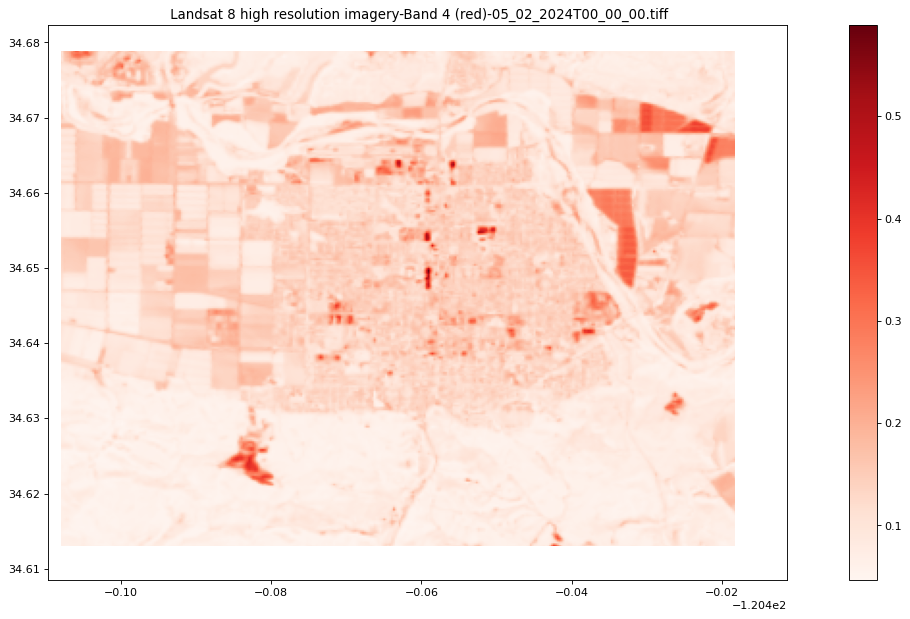

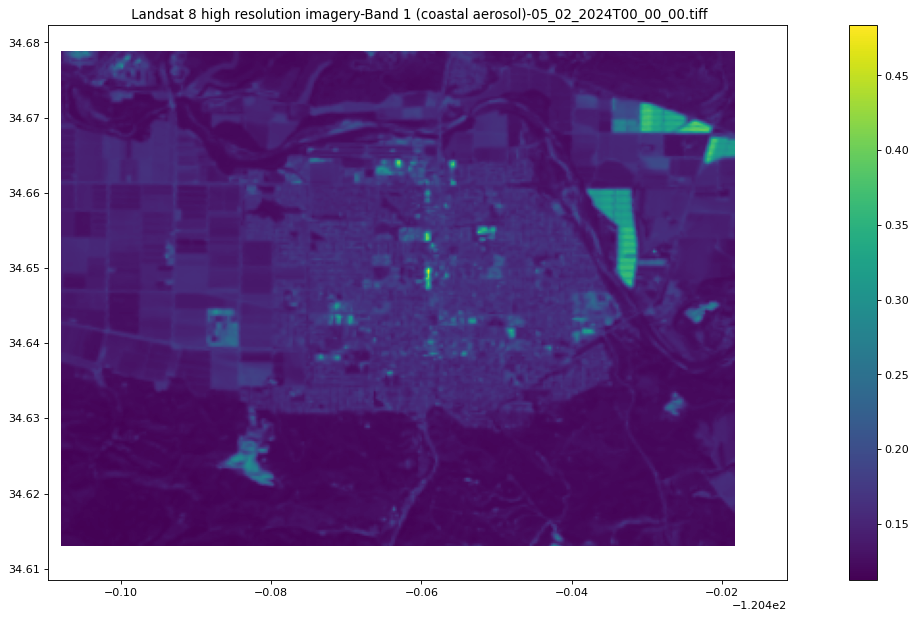

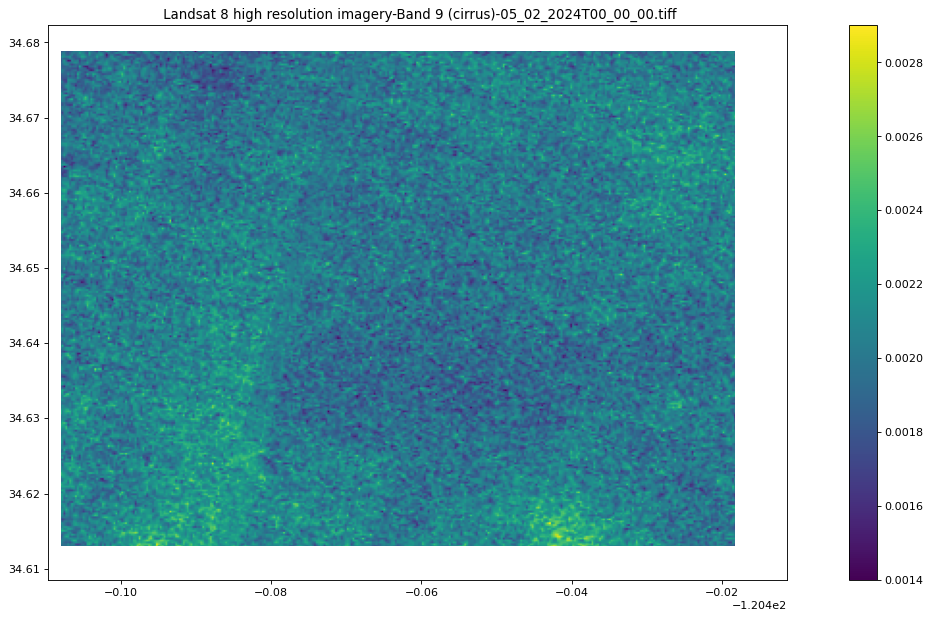

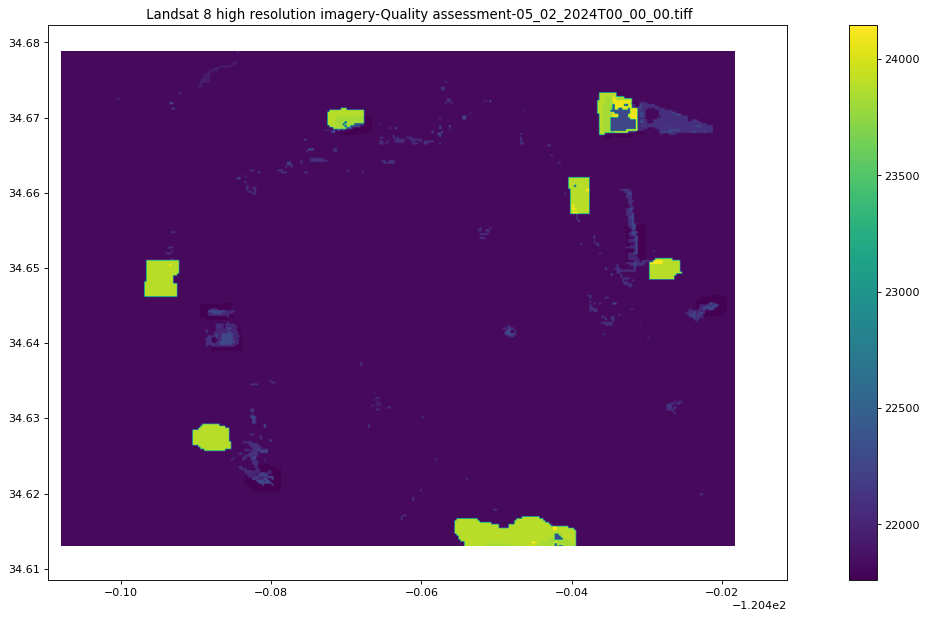

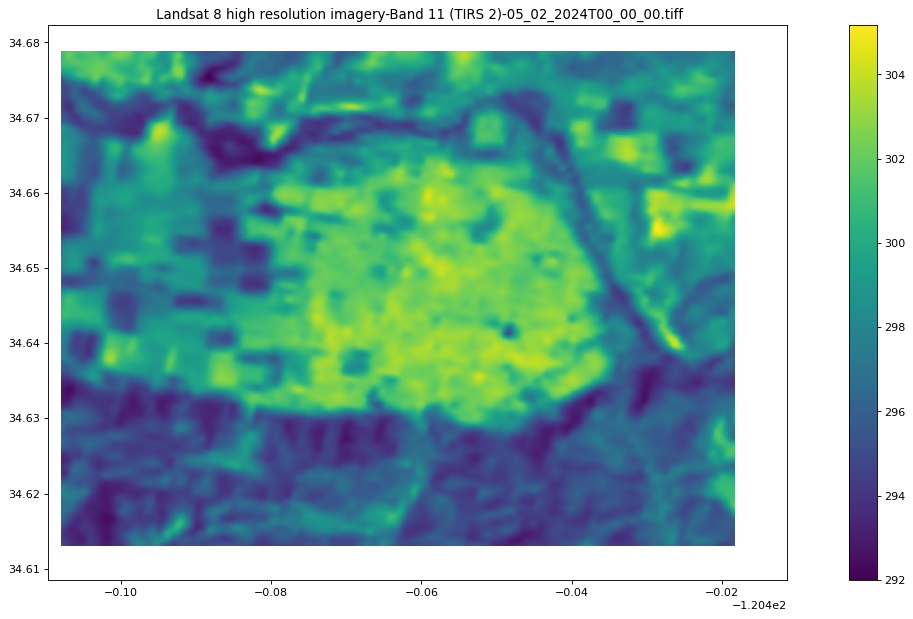

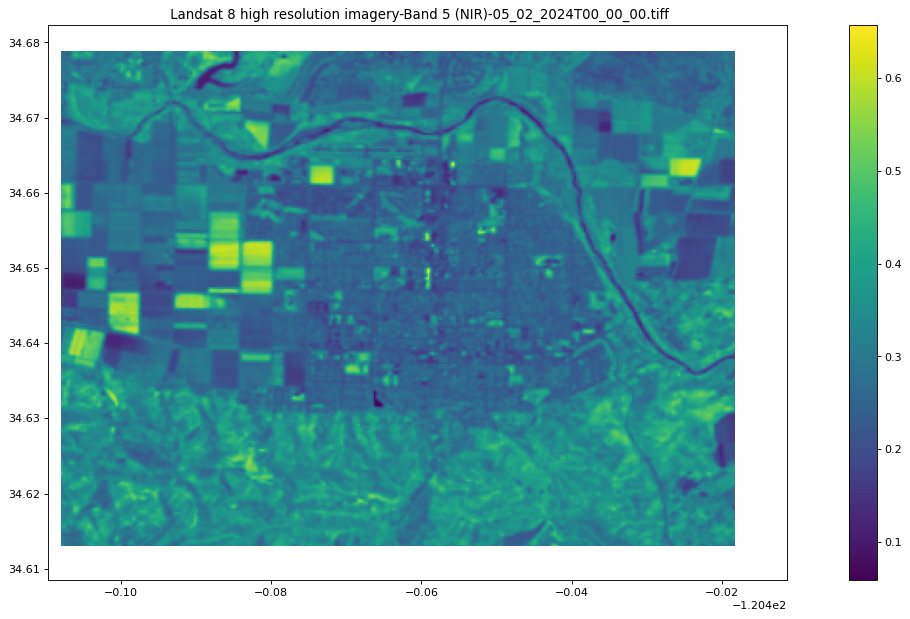

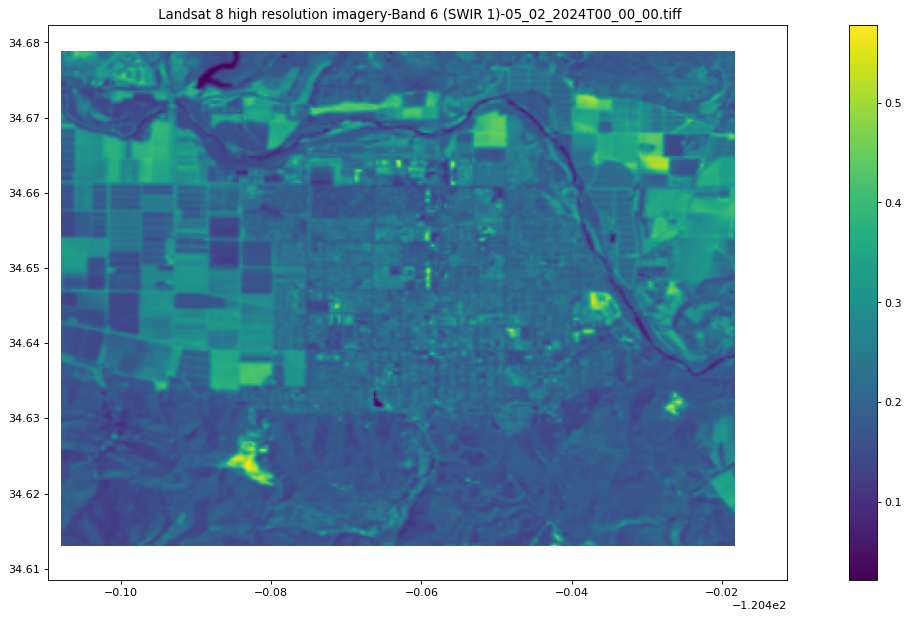

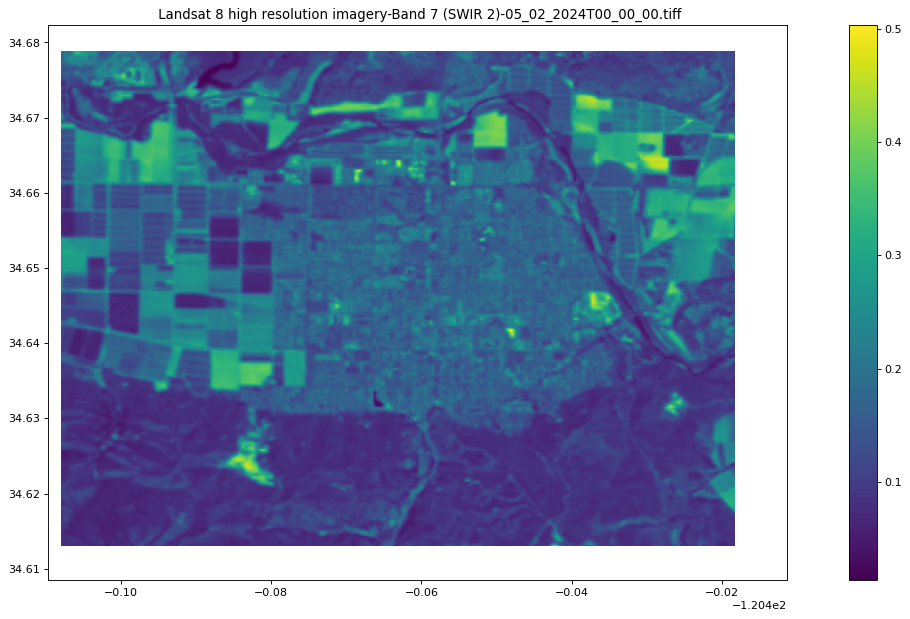

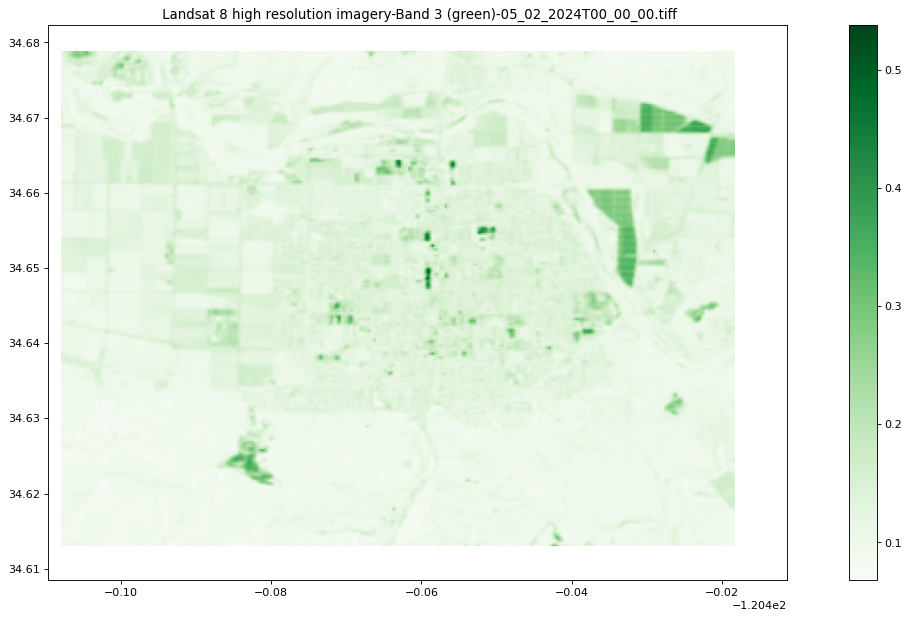

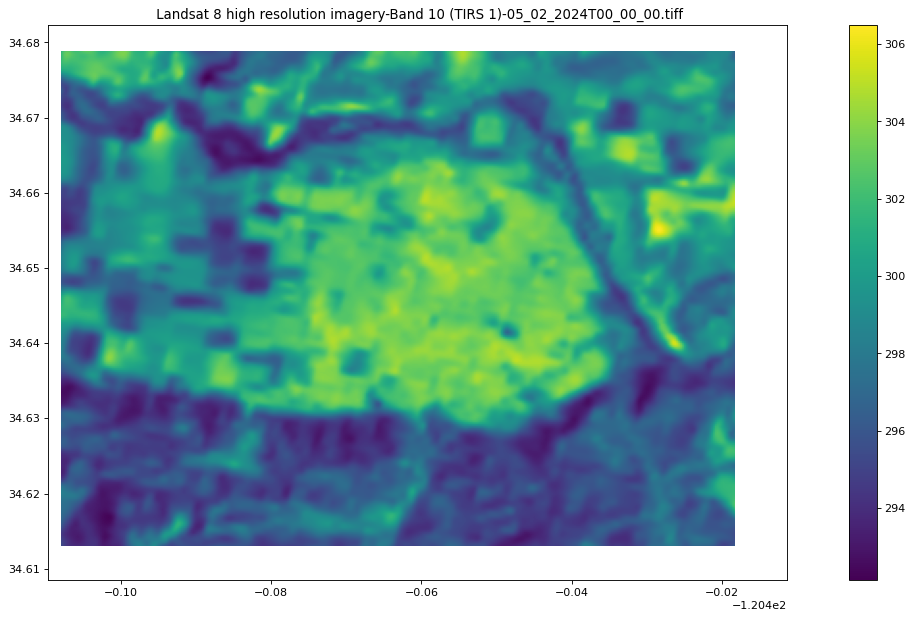

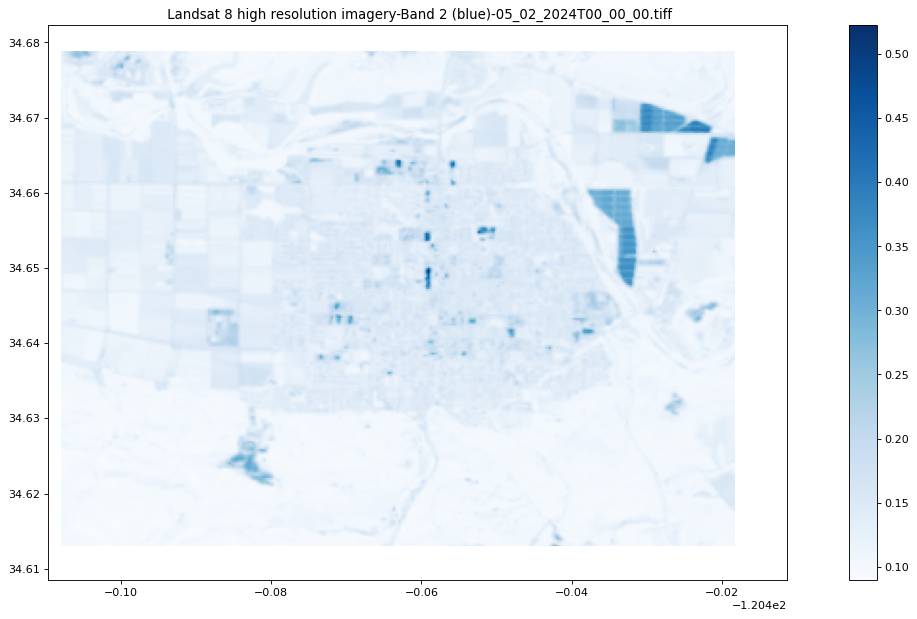

In [7]:
# Function to display the resulting Tiff(s).
Landsat8_Result_file_list = Landsat8Result.list_files()
output_image_array = []
for file in Landsat8_Result_file_list:
    if file.endswith('.tiff'): #display the raster images
        with open(file+'.json', 'r') as summary_file:
            fileparms = json.load(summary_file)
        boundingBox=fileparms["boundingBox"]
        pixelStatistics=fileparms["rasterStatistics"]
        myextent=[boundingBox["minLongitude"],
                  boundingBox["maxLongitude"],
                  boundingBox["minLatitude"],
                  boundingBox["maxLatitude"]]  
        arraylandsat = np.array(PILImage.open(file))
        mask = (arraylandsat == -9999)
        # Masked array to exclude NO Data points from plotting
        masked_array = np.ma.masked_array(arraylandsat, mask)
        plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
        if 'red' in file:
            colormap = 'Reds'
        elif 'blue' in file:
            colormap = 'Blues'
        elif 'green' in file:
            colormap = 'Greens'
        else:
            colormap = 'viridis'  # Default colormap
        plt.imshow(masked_array,
           cmap=colormap,  # Apply the selected colormap
           vmin=pixelStatistics["pixelMin"],
           vmax=pixelStatistics["pixelMax"],
           extent=myextent)  # Load the raster data and set the extent
        plt.colorbar() # Adds the color bar
        plt.title(" "+os.path.basename(file)) 
        output_image_path = os.path.splitext(os.path.basename(file))[0] + ".png"
        plt.savefig(output_image_path, bbox_inches='tight')
        output_image_array.append(output_image_path)
        plt.close()

for output_image in output_image_array:
    #display the raster images
    display(Image(output_image))

Each of the images above represent information on different bands that capture data across different parts of the electromagnetic spectrum for the specified location and temporal time period. Each band captures information that can be used for different applications, for example, the Shortwave infrared (SWIR 1) and Shortwave infrared (SWIR 2) bands together are useful to differentiate wet Earth from dry Earth, and for geology such as rock-soil differentiation, the coastal aerosol band is used for imaging shallow water and tracking fine particles like dust and smoke and the cirrus band is specifically designed to detect cirrus clouds, which are high-altitude, thin clouds that often cause image distortion.

### References
- https://www.usgs.gov/landsat-missions/landsat-collection-2
- https://landsat.gsfc.nasa.gov/satellites/landsat-8/